<a href="https://colab.research.google.com/github/Sidharth-Darwin/OpenCV_Projects/blob/main/ImageRetreivalColorHistogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
!pip install datasets

# Image Retreival using Color Histogram

Program that uses content based image retrieval using color historgram in order to fetch similar images.

Inspired by this [youtube](https://youtu.be/I3na13AESjw?si=MThIjTR2YqhFOApT) video.


In [128]:
from base64 import b64decode
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from datasets import load_dataset

In [129]:
ds = load_dataset("pinecone/image-set")

In [130]:
ds["train"]

Dataset({
    features: ['image_bytes', 'image'],
    num_rows: 21
})

In [131]:
ds["train"][0]

{'image_bytes': '/9j/4AAQSkZJRgABAQEASABIAAD/4gIcSUNDX1BST0ZJTEUAAQEAAAIMbGNtcwIQAABtbnRyUkdCIFhZWiAH3AABABkAAwApADlhY3NwQVBQTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWxjbXMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAApkZXNjAAAA/AAAAF5jcHJ0AAABXAAAAAt3dHB0AAABaAAAABRia3B0AAABfAAAABRyWFlaAAABkAAAABRnWFlaAAABpAAAABRiWFlaAAABuAAAABRyVFJDAAABzAAAAEBnVFJDAAABzAAAAEBiVFJDAAABzAAAAEBkZXNjAAAAAAAAAANjMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB0ZXh0AAAAAElYAABYWVogAAAAAAAA9tYAAQAAAADTLVhZWiAAAAAAAAADFgAAAzMAAAKkWFlaIAAAAAAAAG+iAAA49QAAA5BYWVogAAAAAAAAYpkAALeFAAAY2lhZWiAAAAAAAAAkoAAAD4QAALbPY3VydgAAAAAAAAAaAAAAywHJA2MFkghrC/YQPxVRGzQh8SmQMhg7kkYFUXdd7WtwegWJsZp8rGm/fdPD6TD////bAIQAAgMDAwQDBAUFBAYGBgYGCAgHBwgIDQkKCQoJDRMMDgwMDgwTERQRDxEUER4YFRUYHiMdHB0jKiUlKjUyNUVFXAECAwMDBAMEBQUEBgYGBgYICAcHCAgNCQoJCgkNEwwODAwODBMRFBEPERQRHhgVFRgeIx0cHSMqJSUqNTI1RUVc/8IAEQgGQAoAAwEiAAIRAQMRAf/EADgAAAEFAQEBAQEAAAAAAAAAAAQ

In [132]:
type(ds["train"][0]["image_bytes"])

str

In [133]:
np.frombuffer(b64decode(ds["train"][0]["image_bytes"]), np.uint8)

array([255, 216, 255, ...,  80, 255, 217], dtype=uint8)

In [134]:
cv2.imdecode(np.frombuffer(b64decode(ds["train"][0]["image_bytes"]), np.uint8), cv2.IMREAD_COLOR).shape

(1600, 2560, 3)

In [135]:
def get_image(sample):
    img_str = sample["image_bytes"]
    image = cv2.imdecode(
        np.frombuffer(b64decode(img_str), np.uint8),
        cv2.IMREAD_COLOR
    )
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

get_image(ds["train"][0]).shape

(1600, 2560, 3)

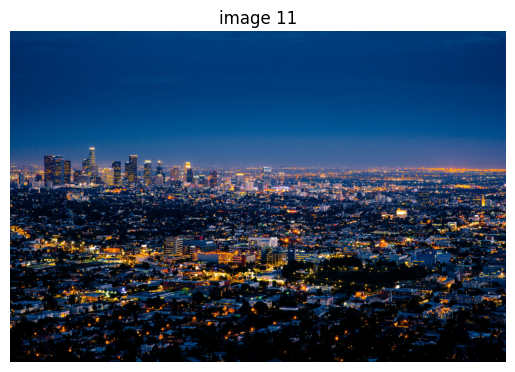

In [136]:
random_index = random.randint(0, len(ds["train"]))
plt.imshow(get_image(ds["train"][random_index]))
plt.title(f"image {random_index}")
plt.axis(False)
plt.show()

In [137]:
images = [get_image(sample) for sample in ds["train"]]
len(images)

21

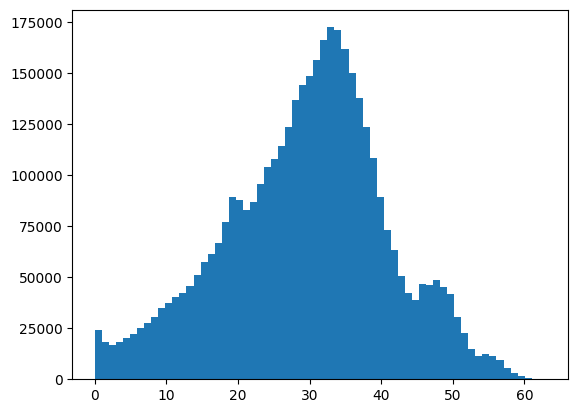

In [138]:
plt.hist((images[0][:, :, 1] / 4).astype(np.uint8).reshape(-1), 64)
plt.show()

In [139]:
def create_histogram(image, n_bins=64):
    div = 256 // n_bins
    plt.imshow(image)
    plt.axis(False)
    plt.show()
    image = (image / div).astype(np.uint8).reshape(-1, 3)
    red = image[:, 0]
    green = image[:, 1]
    blue = image[:, 2]
    fig, axs  = plt.subplots(1, 3)
    fig.set_figheight(6)
    fig.set_figwidth(18)
    axs[0].hist(red, n_bins, color="r")
    axs[1].hist(green, n_bins, color="g")
    axs[2].hist(blue, n_bins, color="b")
    plt.show()

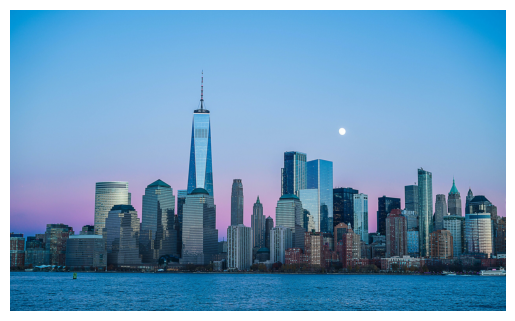

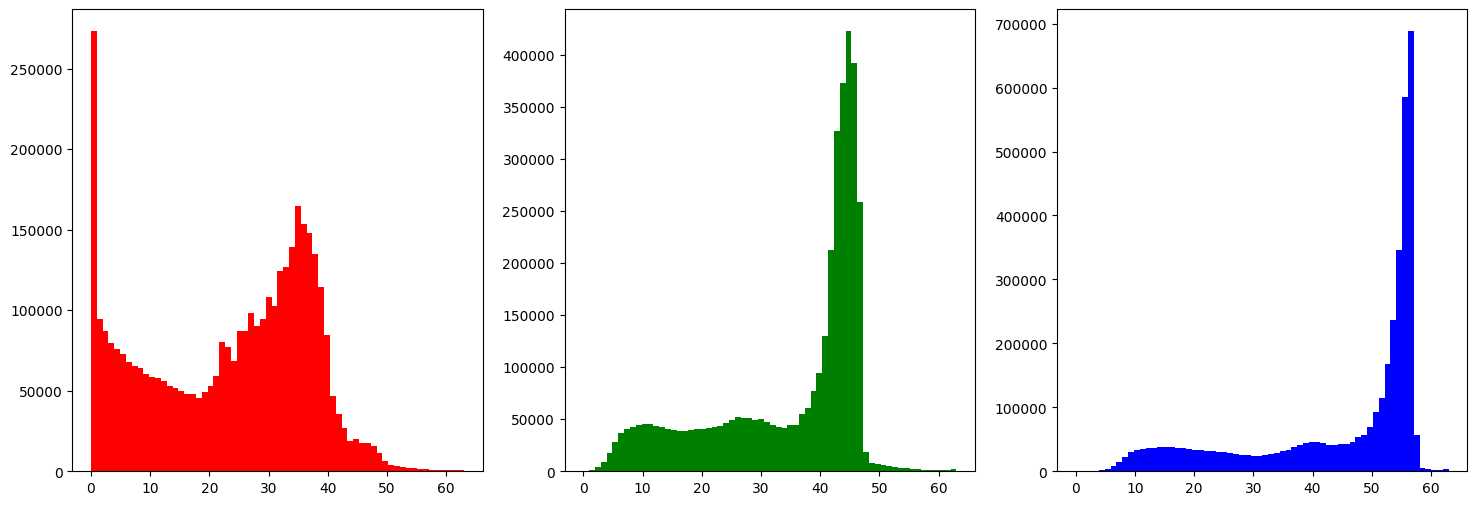

In [140]:
create_histogram(images[1])

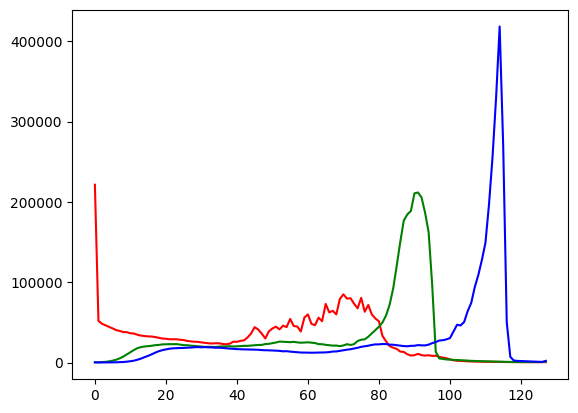

In [141]:
plt.plot(cv2.calcHist([images[1]], [0], None, [128], [0, 256]), color="r")
plt.plot(cv2.calcHist([images[1]], [1], None, [128], [0, 256]), color="g")
plt.plot(cv2.calcHist([images[1]], [2], None, [128], [0, 256]), color="b")
plt.show()

In [142]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

cosine_similarity([1, 2, 4], [1, 3, 5])

0.9959100033104787

In [143]:
def get_image_encoded_vector(image, n_bins=64):
    red_hist = cv2.calcHist([image], [0], None, [n_bins], [0, 256])
    green_hist = cv2.calcHist([image], [1], None, [n_bins], [0, 256])
    blue_hist = cv2.calcHist([image], [2], None, [n_bins], [0, 256])
    vector = np.concatenate([red_hist, green_hist, blue_hist], axis=0).reshape(-1)
    return vector

In [144]:
get_image_encoded_vector(images[0]).shape

(192,)

In [145]:
cosine_similarity(encoded_images[0], encoded_images[2])

0.5760738

In [146]:
encoded_images = [get_image_encoded_vector(image) for image in images]

def find_similar_images(image, k=5, n_bins=128):
    image_enc = get_image_encoded_vector(image, n_bins)
    sorted_indices = sorted(
        list(range(0, len(images))),
        key=lambda x: cosine_similarity(image_enc, get_image_encoded_vector(images[x], n_bins)),
        reverse=True
    )
    return [images[indice] for indice in sorted_indices[:k]]

In [147]:
find_similar_images(images[0])

[array([[[134, 174, 165],
         [142, 182, 173],
         [145, 185, 176],
         ...,
         [ 83, 172, 170],
         [ 87, 176, 174],
         [ 86, 175, 173]],
 
        [[144, 184, 175],
         [143, 183, 174],
         [144, 184, 175],
         ...,
         [ 81, 170, 168],
         [ 85, 174, 172],
         [ 83, 172, 170]],
 
        [[149, 189, 180],
         [145, 185, 176],
         [144, 184, 175],
         ...,
         [ 85, 171, 170],
         [ 88, 174, 173],
         [ 87, 173, 172]],
 
        ...,
 
        [[ 27,  31,   6],
         [ 27,  31,   6],
         [ 27,  31,   6],
         ...,
         [ 79,  86,  79],
         [ 77,  83,  79],
         [ 79,  85,  81]],
 
        [[ 29,  35,   9],
         [ 29,  35,   9],
         [ 29,  35,   9],
         ...,
         [ 63,  69,  65],
         [ 58,  64,  60],
         [ 58,  64,  60]],
 
        [[ 38,  44,  18],
         [ 38,  44,  18],
         [ 39,  45,  19],
         ...,
         [ 49,  55,  51],
  

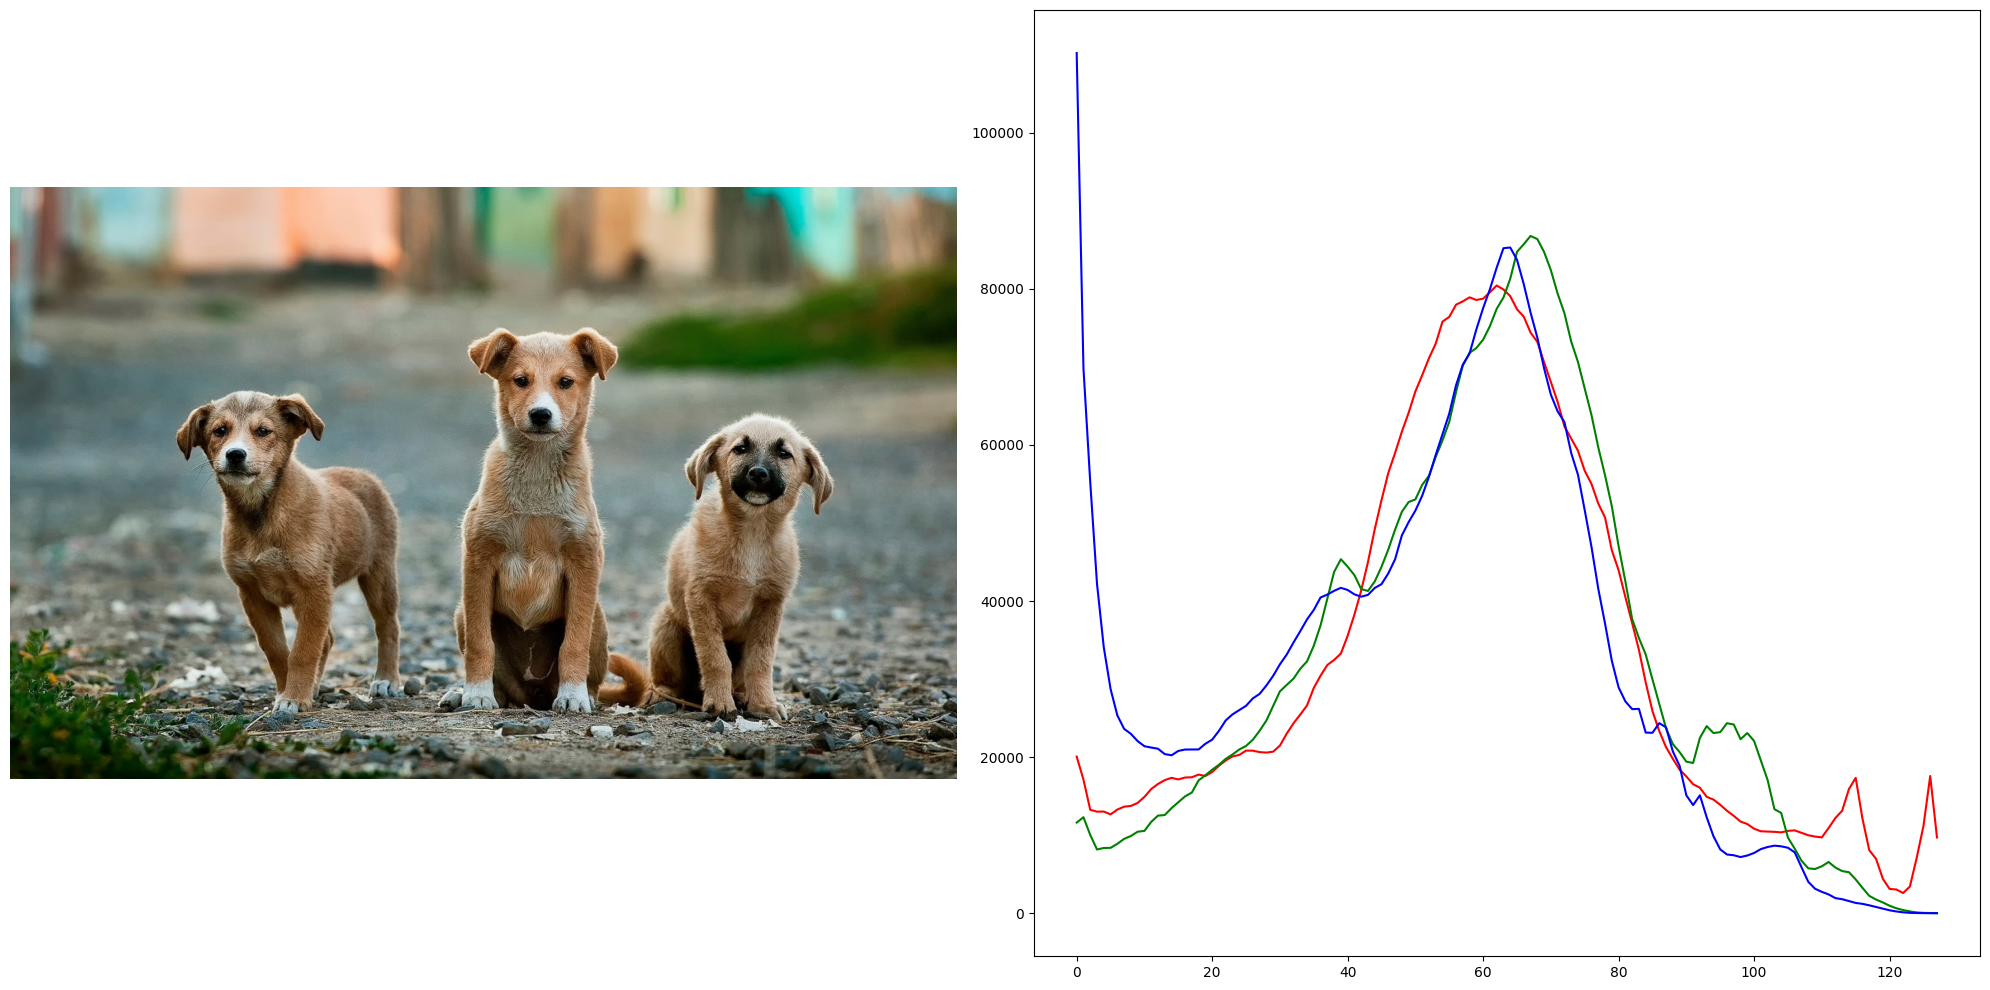

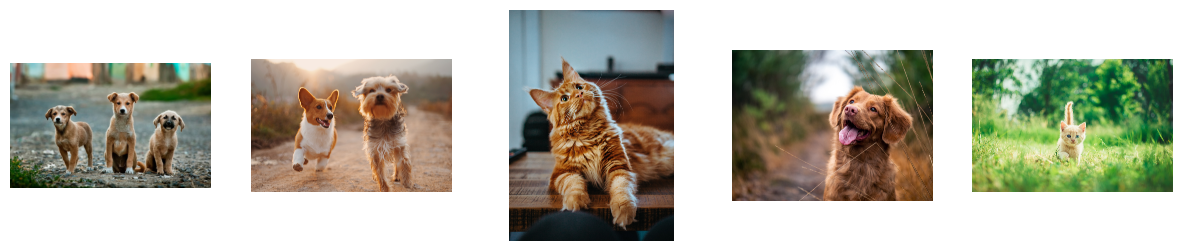

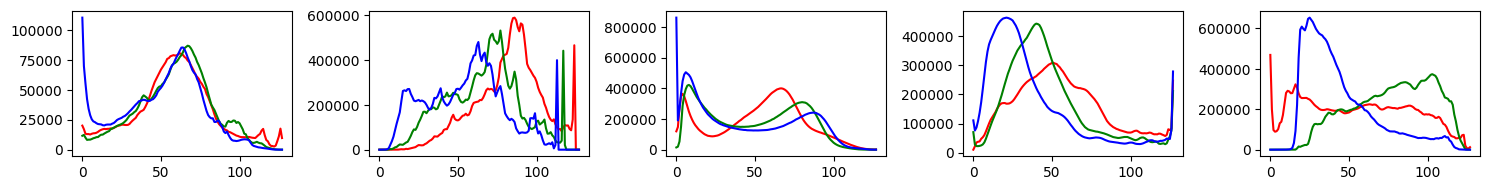

In [160]:
image = images[0]
n_bins = 128
n_similar_images = 5
red_hist = cv2.calcHist([image], [0], None, [n_bins], [0, 256])
green_hist = cv2.calcHist([image], [1], None, [n_bins], [0, 256])
blue_hist = cv2.calcHist([image], [2], None, [n_bins], [0, 256])
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(10)
axs[0].imshow(image)
axs[0].axis(False)
axs[1].plot(red_hist, color="r")
axs[1].plot(green_hist, color="g")
axs[1].plot(blue_hist, color="b")
fig.tight_layout()
plt.show()
fig, axs = plt.subplots(1, n_similar_images)
fig.set_figwidth(3*n_similar_images)
fig.set_figheight(3)
similar_images = find_similar_images(image, k=n_similar_images)
for i, img in enumerate(similar_images):
    axs[i].imshow(img)
    axs[i].axis(False)
plt.show()
fig, axs = plt.subplots(1, n_similar_images)
fig.set_figwidth(3*n_similar_images)
fig.set_figheight(2)
for i, img in enumerate(similar_images):
    axs[i].plot(cv2.calcHist([img], [0], None, [n_bins], [0, 256]), color="r")
    axs[i].plot(cv2.calcHist([img], [1], None, [n_bins], [0, 256]), color="g")
    axs[i].plot(cv2.calcHist([img], [2], None, [n_bins], [0, 256]), color="b")
fig.tight_layout()
plt.show()

In [162]:
def plot_similar_images(image, n_similar_images=5, n_bins=64):
    red_hist = cv2.calcHist([image], [0], None, [n_bins], [0, 256])
    green_hist = cv2.calcHist([image], [1], None, [n_bins], [0, 256])
    blue_hist = cv2.calcHist([image], [2], None, [n_bins], [0, 256])
    fig, axs = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axs[0].imshow(image)
    axs[0].axis(False)
    axs[1].plot(red_hist, color="r")
    axs[1].plot(green_hist, color="g")
    axs[1].plot(blue_hist, color="b")
    fig.tight_layout()
    plt.show()
    fig, axs = plt.subplots(1, n_similar_images)
    fig.set_figwidth(3*n_similar_images)
    fig.set_figheight(3)
    similar_images = find_similar_images(image, k=n_similar_images)
    for i, img in enumerate(similar_images):
        axs[i].imshow(img)
        axs[i].axis(False)
    plt.show()
    fig, axs = plt.subplots(1, n_similar_images)
    fig.set_figwidth(3*n_similar_images)
    fig.set_figheight(2)
    for i, img in enumerate(similar_images):
        axs[i].plot(cv2.calcHist([img], [0], None, [n_bins], [0, 256]), color="r")
        axs[i].plot(cv2.calcHist([img], [1], None, [n_bins], [0, 256]), color="g")
        axs[i].plot(cv2.calcHist([img], [2], None, [n_bins], [0, 256]), color="b")
    fig.tight_layout()
    plt.show()

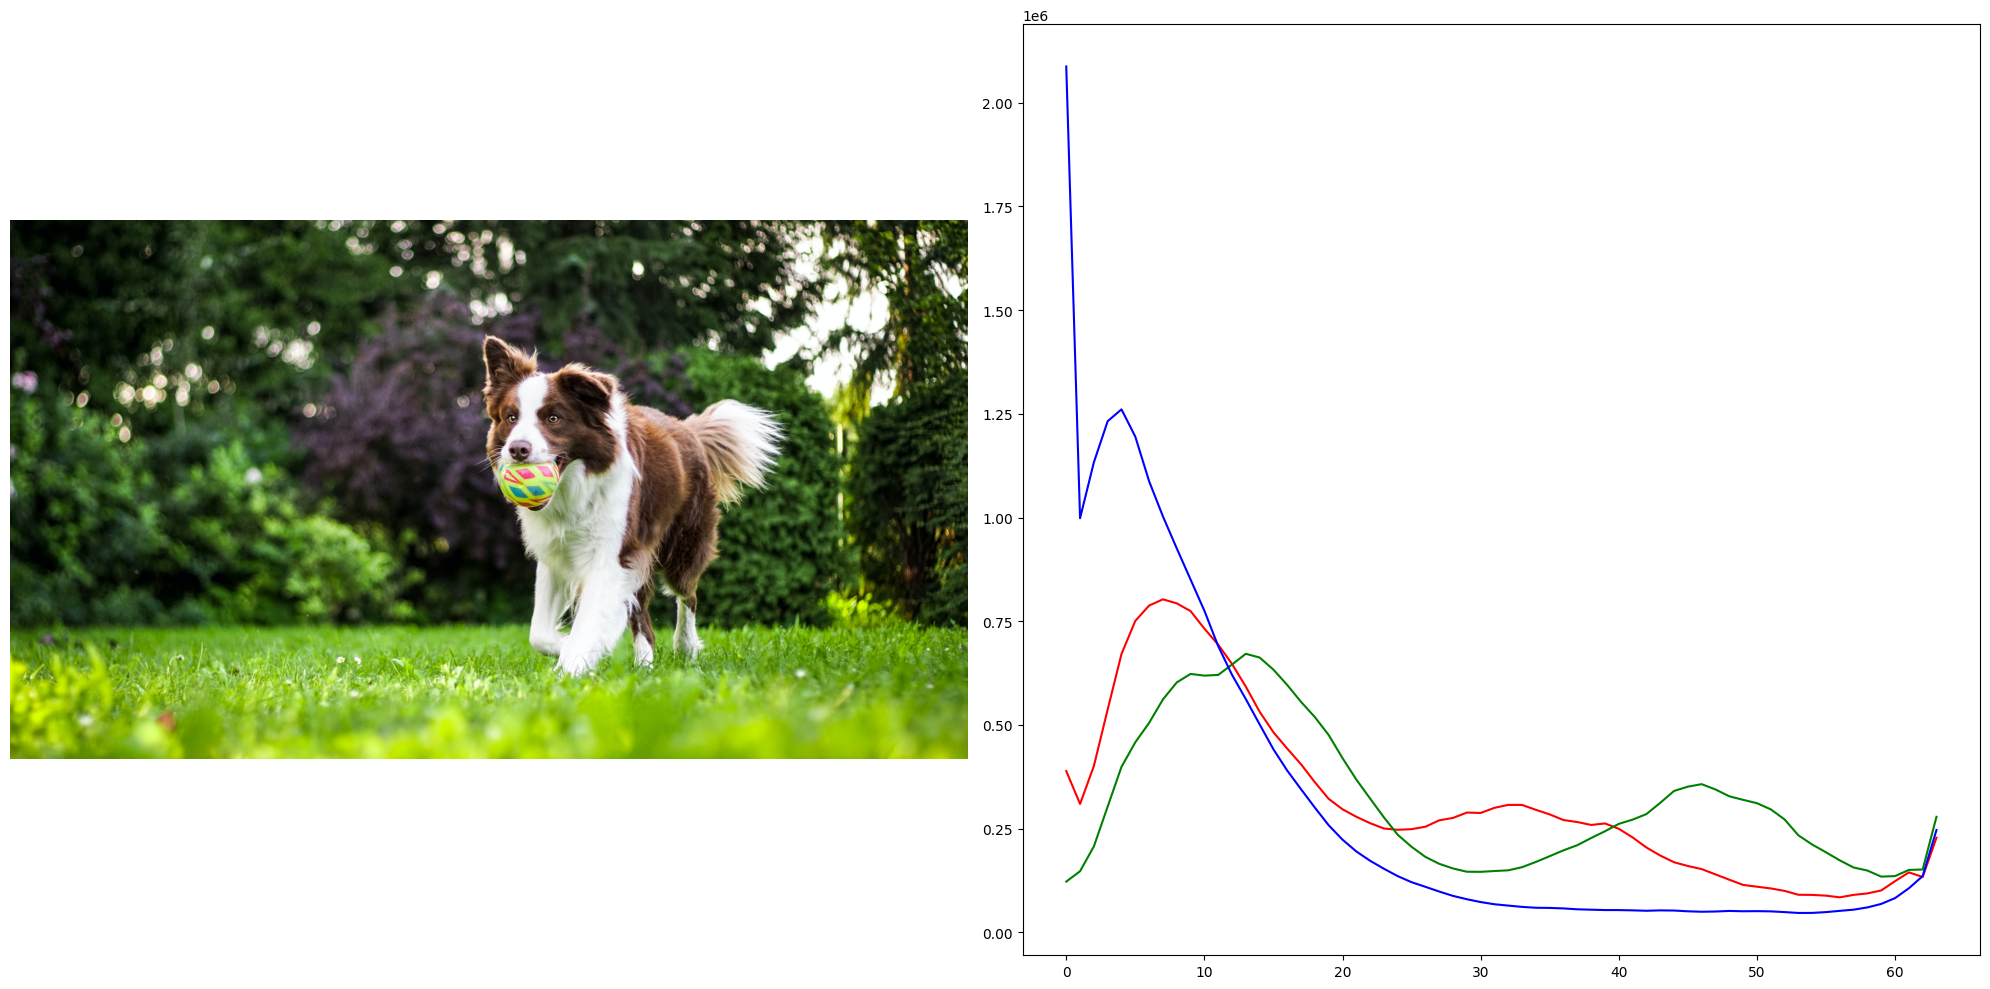

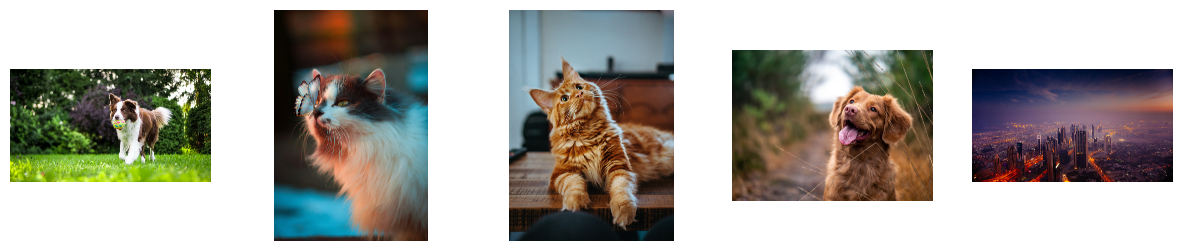

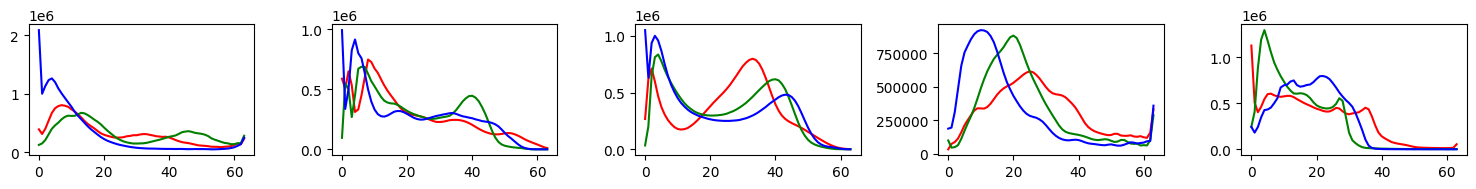

In [164]:
plot_similar_images(images[2])